# Word2Vec + SVM

Binary sentiment classification using pre-trained Word2Vec embeddings (mean pooling) with an RBF SVM.

Prerequisite: run `00_preprocessing.ipynb` first.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and split

In [2]:
df = pd.read_csv('../data/reviews_extraidas.csv')
df['label'] = (df['Y'] > 5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df['X'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 435, Test: 109


## Word2Vec embeddings

In [3]:
!pip install -q gensim

zsh:1: /Users/pedrofonsecadeandrade/Dev/GitHub/phd-natural-processing-language/.venv/bin/pip: bad interpreter: /Users/pedrofonsecadeandrade/Dev/phd-nlp/.venv/bin/python: no such file or directory

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Frameworks/Python.framework/Versions/3.13/bin/python3.13 -m pip install --upgrade pip


In [8]:
import gensim.downloader

w2v = gensim.downloader.load('word2vec-google-news-300')
print(f"Embedding dim: {w2v.vector_size}")

Embedding dim: 300


In [9]:
def text_to_embedding(text, model, dim=300):
    words = text.lower().split()
    vectors = [model[w] for w in words if w in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_train_w2v = np.array([text_to_embedding(t, w2v) for t in X_train])
X_test_w2v = np.array([text_to_embedding(t, w2v) for t in X_test])

print(f"Train shape: {X_train_w2v.shape}")
print(f"Test shape:  {X_test_w2v.shape}")

Train shape: (435, 300)
Test shape:  (109, 300)


## Train SVM

In [10]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_w2v, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


## Evaluation

In [11]:
y_pred = svm.predict(X_test_w2v)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 (macro): {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print()
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.7156
F1 (macro): 0.6136
F1 (weighted): 0.6628

              precision    recall  f1-score   support

    Negative       0.69      0.99      0.81        68
    Positive       0.92      0.27      0.42        41

    accuracy                           0.72       109
   macro avg       0.80      0.63      0.61       109
weighted avg       0.78      0.72      0.66       109



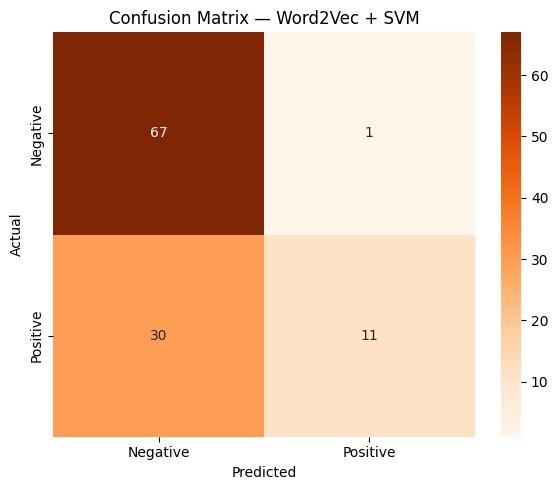

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — Word2Vec + SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## With class balancing

In [13]:
svm_balanced = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)
svm_balanced.fit(X_train_w2v, y_train)

y_pred_bal = svm_balanced.predict(X_test_w2v)

print(f"Accuracy: {accuracy_score(y_test, y_pred_bal):.4f}")
print(f"F1 (macro): {f1_score(y_test, y_pred_bal, average='macro'):.4f}")
print(f"F1 (weighted): {f1_score(y_test, y_pred_bal, average='weighted'):.4f}")
print()
print(classification_report(y_test, y_pred_bal, target_names=['Negative', 'Positive']))

Accuracy: 0.7890
F1 (macro): 0.7816
F1 (weighted): 0.7916

              precision    recall  f1-score   support

    Negative       0.87      0.78      0.82        68
    Positive       0.69      0.80      0.74        41

    accuracy                           0.79       109
   macro avg       0.78      0.79      0.78       109
weighted avg       0.80      0.79      0.79       109



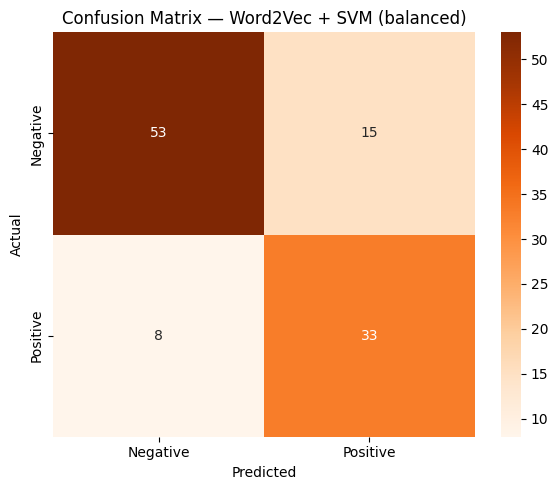

In [14]:
cm_bal = confusion_matrix(y_test, y_pred_bal)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_bal, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — Word2Vec + SVM (balanced)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Inference on new reviews

In [15]:
samples = [
    "This movie was absolutely amazing! I loved every moment of it.",
    "Terrible film. Waste of time and money. Do not watch.",
    "It was okay, nothing special but not bad either.",
]

X_samples = np.array([text_to_embedding(t, w2v) for t in samples])
preds = svm_balanced.predict(X_samples)
label_map = {0: 'Negative', 1: 'Positive'}

for text, pred in zip(samples, preds):
    print(f"{label_map[pred]:>8s}  |  {text}")

Negative  |  This movie was absolutely amazing! I loved every moment of it.
Negative  |  Terrible film. Waste of time and money. Do not watch.
Negative  |  It was okay, nothing special but not bad either.
